In [ ]:
# pip install textblob
!pip install -U textblob

In [53]:
# Load preprocess, emoji functions
from ipynb.fs.defs.textblob import convert_emojis, preprocess
from ipynb.fs.full.Unicode_emojis import UNICODE_EMO
import re
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [54]:
# Import dependencies

# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator)
from datetime import datetime


# Load preprocess function

# Load textblob module
from textblob import TextBlob


# set option to see full tweet text
pd.set_option('display.max_colwidth', None)

In [55]:
# Load twitter data
data = pd.read_csv("../Twitter_Data/tweet_data_11.21.20.csv")

# Select columns and rename
columns = ["created_at", "id", "text", "public_metrics.retweet_count", 
           "public_metrics.reply_count", "public_metrics.like_count", "public_metrics.quote_count"]

data = data[columns]
data = data.rename(columns={"public_metrics.retweet_count": "retweets", "public_metrics.reply_count": "replies", 
                            "public_metrics.like_count": "likes", "public_metrics.quote_count": "quotes"})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200373 entries, 0 to 200372
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  200373 non-null  object 
 1   id          200373 non-null  int64  
 2   text        200372 non-null  object 
 3   retweets    200371 non-null  float64
 4   replies     200371 non-null  float64
 5   likes       200371 non-null  float64
 6   quotes      200371 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 10.7+ MB


In [56]:
# Drop null values; check for duplicate data

data = data.dropna()
data.reset_index(drop=True)

,created_at,id,text,retweets,replies,likes,quotes
0,2020-11-21T14:42:11.000Z,1330159581255897095,"Man, we were ready to play with COVID positive players.\n\nFixed that for ya, Trevor! https://t.co/DxgpLNroKr",0.0,0.0,0.0,0.0
1,2020-11-21T14:42:11.000Z,1330159581226557442,"@DiscernedEd @mmjblair @emilia_suze My dad had his flu vax a couple of wks ago, 2 days later woke during night with high temp, pounding headache and next morning had lost his sense of smell! He booked a covid test which came back negative. Coincidence? Who knows.",0.0,0.0,0.0,0.0
2,2020-11-21T14:42:11.000Z,1330159581121695748,Congratulations! @msm_prc @MSM_NCPC @COVID_19Network https://t.co/aOIrw2uyke,0.0,0.0,0.0,0.0
3,2020-11-21T14:42:11.000Z,1330159581104889856,"After spending a lot of time with my mom in the hospital for a week, I have scheduled an appointment for a covid test for tomorrow morning. I feel fine but I want to protect those around me just incase I am asymptomatic. I don't want to unknowingly put others at risk.",0.0,0.0,0.0,0.0
4,2020-11-21T14:42:11.000Z,1330159580786077704,My last ex girlfriend said Covid was a ploy to get all the depressed people locked into their homes to basically kill themselves off. That shit lives rent free in my head lol.,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
200366,2020-11-22T02:02:03.000Z,1330330672553189381,"Laci's one last time tonight. So long and thanks for all the memories. Order takeout if you do it, the COVID setup is really rough.",0.0,0.0,0.0,0.0
200367,2020-11-22T02:02:03.000Z,1330330672238571520,"@hungryjanis Nah. You got to live well!!! If you’re paying interest, always pay off the highest first if you got multiple things to pay. If COVID is helping your pocket (bc of WFH) take advantage!!",0.0,0.0,0.0,0.0
200368,2020-11-22T02:02:03.000Z,1330330672188297217,WATCH clashes break out in Germany after rally against Covid-19 lockdown canceled last minute https://t.co/cieXsj9inv https://t.co/twqQK0y28J,0.0,0.0,0.0,0.0
200369,2020-11-22T02:02:02.000Z,1330330671022288899,THIS is why we can't get a grip on COVID. https://t.co/rjkI7mtNuu,0.0,0.0,0.0,0.0


In [57]:
# Convert "created_at" from ISO 8601 to datetime; extract year and time info; round time to minutes

data["created_at"] = pd.to_datetime(data["created_at"], utc=True)
data["date"] = data["created_at"].dt.date
data["time"] = data["created_at"].dt.round('min').dt.time

In [58]:
# Convert all tweets to a list
tweet_list = list(data["text"])

In [59]:
# confirm list is correct
len(tweet_list)

200371

In [15]:
# Define dictionaries

# Regex patterns
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
user_pattern = r"@[^\s]+"

#POS tags for lemmatization
tag_dict = {"J": 'a', 
            "N": 'n', 
            "V": 'v', 
            "R": 'r'}

# Stop words list (from NLTK corpus)
stopwords_list = stopwords.words("english")

# Thanks to this code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# Define regex pattern to look for (unicode representation for all emojis)
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

In [17]:
# Begin function
def convert_emojis(text):
    
    # Find all emojis
    emotes = re.findall(emoji_pattern, text)
    
    # Loop through emojis and sub the emoji with literal words using UNICODE_EMO dictionary 
    for emote in emotes:
        try:
            text = re.sub(emote, UNICODE_EMO[emote].replace(":"," ").replace("_"," "), text)
        except KeyError:
            continue 
    
    return text

In [19]:
def preprocess(data):
    preprocessed_tweets = []
    # Loop through all tweets
    for tweet in data:
        
        # Replace emojis with words (convert_emojis function defined above)
        tweet = convert_emojis(tweet)
        
        # Remove all urls and usernames
        tweet = re.sub(url_pattern, "", tweet)
        tweet = re.sub(user_pattern, "", tweet)
        
        # Remove all stopwords 
        no_stop_tweet = ""
        for word in tweet.split():
            if word not in stopwords_list:
                no_stop_tweet += (word+" ")
        
        # Create textblob object 
        blob = TextBlob(no_stop_tweet)
        
        # Lemmatize the words in the blob
        # See https://textblob.readthedocs.io/en/dev/quickstart.html#words-inflection-and-lemmatization
        
        # Use only the first letter of the obtained tag (tag[0]) to pass into lemmatize() func
        words_and_tags = [(w, tag_dict.get(tag[0], "n")) for w, tag in blob.tags]
        # Lemmatize according to appropriate POS tag 
        lemmatized_words_list = [wd.lemmatize(pos) if pos in 
                                 ("a", "n", "r") else wd for wd, pos in words_and_tags]
        
        # join back into a string 
        preprocessed_tweet = " ".join(lemmatized_words_list)
        # Append to list
        preprocessed_tweets.append(preprocessed_tweet)
        
    return preprocessed_tweets
        

In [20]:
# Preprocess tweets
import time
t = time.time()
preprocessed_tweets = preprocess(tweet_list)
print(f"Processing done. Time to complete: {(time.time() - t)} seconds")

Processing done. Time to complete: 1072.865103006363 seconds


In [ ]:
# Test textblob sentiment analysis

#test = data.loc[0:5]

polarity1 = []
subjectivity1 =[]


for item in range(0, len(test)):
    sent = TextBlob(test['text'][item]).sentiment
    polar = sent[0]
    subject = sent[1]
    polarity1.append(sent[0])
    subjectivity1.append(sent[1])
    print(polar, subject)

# test['polarity'] = polarity
test.insert(9, 'polarity', polarity1, True)
test.insert(10, 'subjectivity', subjectivity1, True)

type(polarity1[0])

In [40]:
# Create polarity and subjectivity measures for full dataset "tweet_data_11.21.20"
vs = SentimentIntensityAnalyzer()
polarity = []
subjectivity =[]
vader_scores = []

for item in preprocessed_tweets:
    try:
        sent = TextBlob(item).sentiment
        polarity.append(sent[0])
        subjectivity.append(sent[1])
        
        vader_score = vs.polarity_scores(item)
        compound = vader_score["compound"]
        vader_scores.append(compound)
    except KeyError:
        polarity.append(float(0))
        subjectivity.append(float(0))
        vader_scores.append(float(0))
        print('KeyError: Continuing')

        

In [62]:
# Insert columns into dataframe
data['polarity'] = polarity
data['subjectivity'] = subjectivity
data["vader_sentiment"] = vader_scores
data.head()

,created_at,id,text,retweets,replies,likes,quotes,date,time,polarity,subjectivity,vader_sentiment
0,2020-11-21 14:42:11+00:00,1330159581255897095,"Man, we were ready to play with COVID positive players.\n\nFixed that for ya, Trevor! https://t.co/DxgpLNroKr",0.0,0.0,0.0,0.0,2020-11-21,14:42:00,0.175758,0.415152,0.8176
1,2020-11-21 14:42:11+00:00,1330159581226557442,"@DiscernedEd @mmjblair @emilia_suze My dad had his flu vax a couple of wks ago, 2 days later woke during night with high temp, pounding headache and next morning had lost his sense of smell! He booked a covid test which came back negative. Coincidence? Who knows.",0.0,0.0,0.0,0.0,2020-11-21,14:42:00,-0.028000,0.188000,-0.8225
2,2020-11-21 14:42:11+00:00,1330159581121695748,Congratulations! @msm_prc @MSM_NCPC @COVID_19Network https://t.co/aOIrw2uyke,0.0,0.0,0.0,0.0,2020-11-21,14:42:00,0.000000,0.000000,0.5994
3,2020-11-21 14:42:11+00:00,1330159581104889856,"After spending a lot of time with my mom in the hospital for a week, I have scheduled an appointment for a covid test for tomorrow morning. I feel fine but I want to protect those around me just incase I am asymptomatic. I don't want to unknowingly put others at risk.",0.0,0.0,0.0,0.0,2020-11-21,14:42:00,0.416667,0.500000,0.4404
4,2020-11-21 14:42:11+00:00,1330159580786077704,My last ex girlfriend said Covid was a ploy to get all the depressed people locked into their homes to basically kill themselves off. That shit lives rent free in my head lol.,0.0,0.0,0.0,0.0,2020-11-21,14:42:00,0.250000,0.591667,-0.7579


In [63]:
# ---------------------------------------------------------------------
# Plot sentiment polarity and objectivity
# ---------------------------------------------------------------------

In [66]:
## Create dataframe for plotting sentiment polarity and objectivity

# Group data by time to create sentiment sentiment plot by minute
plot_data = data.groupby('time').mean()
plot_data = plot_data[['polarity', 'subjectivity', 'vader_sentiment']]

# Reset index to create separate time column
plot_data = plot_data.reset_index()

# Format time column as string value
plot_data['time'] = plot_data['time'].astype(str)

# Save as CSV file
plot_data.to_csv('../Twitter_Data/sentiment_plot_data.csv', index=False)

# Display ouput
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             681 non-null    object 
 1   polarity         681 non-null    float64
 2   subjectivity     681 non-null    float64
 3   vader_sentiment  681 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.4+ KB


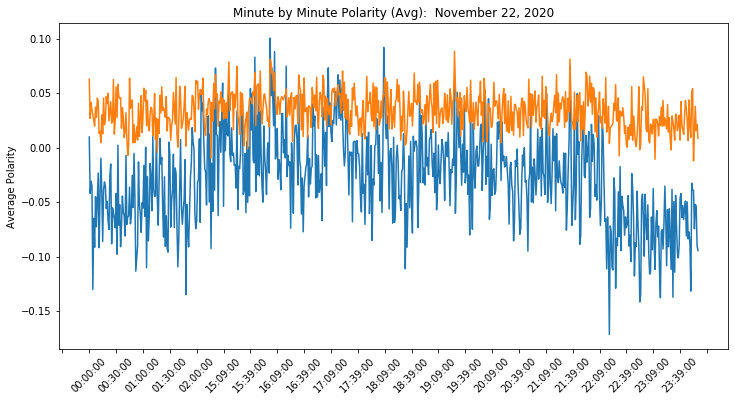

In [45]:
# Graph polarity of sentiment trend

x_axis = plot_data['time']
y1_axis = plot_data['vader_sentiment']
y2_axis = plot_data['polarity']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Minute by Minute Polarity (Avg):  November 22, 2020")
plt.ylabel("Average Polarity")
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.plot(x_axis, y1_axis, y2_axis)
plt.xticks(rotation=45)

plt.show()

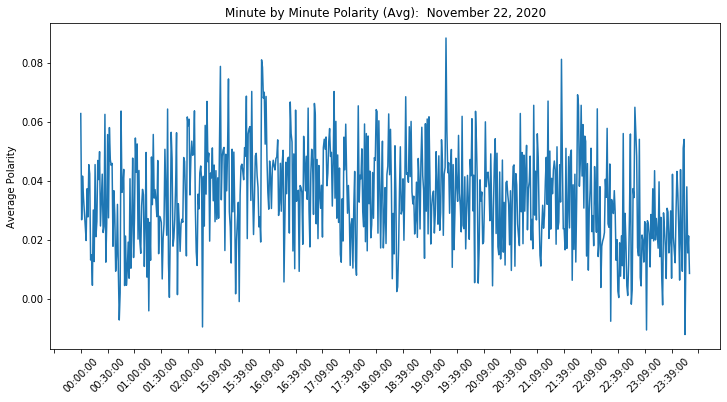

In [25]:
# Graph polarity of sentiment trend

x_axis = plot_data['time']
y1_axis = plot_data['polarity']
y2_axis = plot_data['subjectivity']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Minute by Minute Polarity (Avg):  November 22, 2020")
plt.ylabel("Average Polarity")
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.plot(x_axis, y1_axis)
plt.xticks(rotation=45)

plt.show()

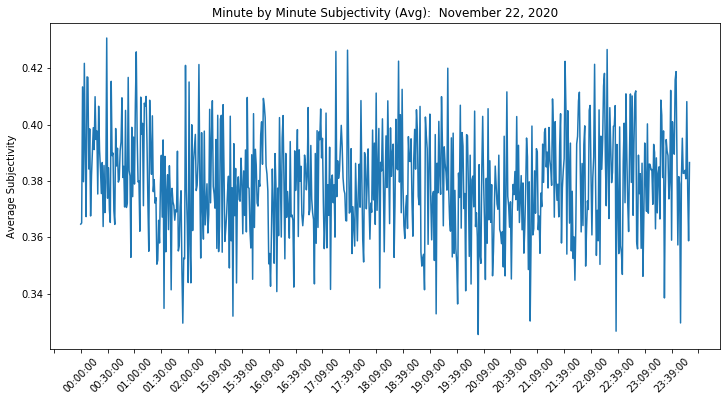

In [26]:
# Graph subjectivity of sentiment trend

x_axis = plot_data['time']
y1_axis = plot_data['polarity']
y2_axis = plot_data['subjectivity']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Minute by Minute Subjectivity (Avg):  November 22, 2020")
plt.ylabel("Average Subjectivity")
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.plot(x_axis, y2_axis)
plt.xticks(rotation=45)

plt.show()

In [27]:
# ---------------------------------------------------------------------
# Plot tweet and retweet count
# ---------------------------------------------------------------------

In [28]:
# Group data by time, count tweest and sum retweets
tweets = data[['time', 'id']].groupby('time').count()
retweets = data[['time', 'retweets']].groupby('time').sum()

# Concatenate datafreams
plot_data1 = tweets.join(retweets)

# Reset index to create separate time column
plot_data1 = plot_data1.reset_index()

# Format time column as string value
plot_data1['time'] = plot_data1['time'].astype(str)

# Display ouput
plot_data1.head()

,time,id,retweets
0,00:00:00,286,17.0
1,00:01:00,297,3.0
2,00:02:00,302,4.0
3,00:03:00,298,6.0
4,00:04:00,284,3.0


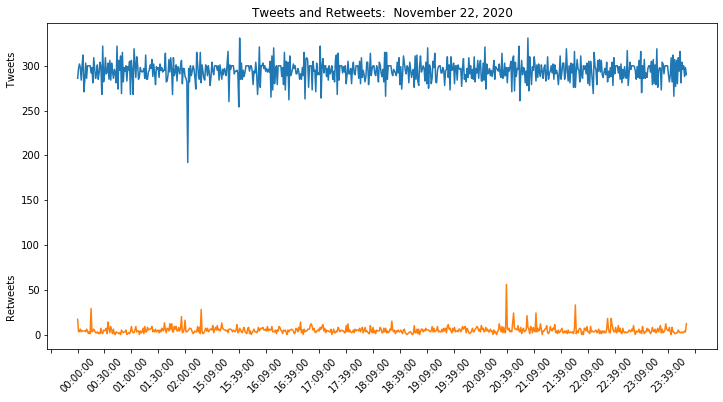

In [29]:
# Graph tweet and retweet count by minute

x_axis = plot_data1['time']
y1_axis = plot_data1['id']
y2_axis = plot_data1['retweets']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Tweets and Retweets:  November 22, 2020")
plt.ylabel("Retweets                                                            Tweets")
ax.plot(x_axis, y1_axis, y2_axis)
ax.xaxis.set_major_locator(MultipleLocator(30))
plt.xticks(rotation=45)

plt.show()

In [30]:
# ---------------------------------------------------------------------
# Identify most retweeted tweets
# ---------------------------------------------------------------------

In [31]:
# Sort data by # retweets
max_retweets = data.sort_values(by='retweets', ascending=False)
max_retweets.head(5)


,created_at,id,text,retweets,replies,likes,quotes,date,time,polarity,subjectivity
104945,2020-11-21 20:38:27+00:00,1330249235166588932,I’m sitting here thinking how incredible it is we have not one but two Covid vaccines literally around the corner. President Trump eliminated endless red tape and withstood severe criticism to find a solution in record time. It is extremely impressive!,49.0,1.0,171.0,1.0,2020-11-21,20:38:00,0.443750,0.662500
4582,2020-11-21 14:57:14+00:00,1330163367055683586,Absolutely devastating. My heart aches for Raiden and every single person left behind in the wake of COVID-19. Please stay safe this weekend.\nhttps://t.co/MB80XzoCaw,24.0,5.0,139.0,0.0,2020-11-21,14:57:00,-0.194286,0.482857
127684,2020-11-21 21:55:18+00:00,1330268578399088641,"Yesterday there were 0 new cases and 0 lost lives reported. There is 1 active case remaining. We received 10,530 test results – thanks Victoria, #EveryTestHelps. More: https://t.co/pcll7ySEgz \n\n#StaySafeStayOpen #COVID19Vic https://t.co/yijW3KLf3E",22.0,2.0,139.0,5.0,2020-11-21,21:55:00,0.175758,0.438636
114565,2020-11-21 21:10:53+00:00,1330257398146232333,"Raiders will activate seven of the 10 players off their COVID-19 list today, per @PGutierrezESPN.\n\nhttps://t.co/ur47aTgoiQ",20.0,3.0,64.0,0.0,2020-11-21,21:11:00,0.000000,0.000000
138073,2020-11-21 22:30:41+00:00,1330277482487042050,"""Get Out! - Go Get a Warrant!"" - Business Owners in Buffalo, New York Stand Up to Cuomo's Covid Orders, Kick Out Sheriff and ""Health Inspector"" (VIDEO) @CristinaLaila1 via @gatewaypundit https://t.co/oK3uSNQsz5",15.0,1.0,38.0,0.0,2020-11-21,22:31:00,0.136364,0.454545


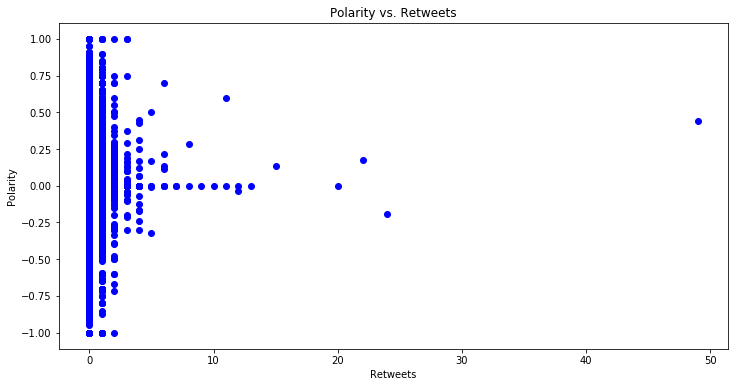

In [32]:
# Plot scatter of retweets and plority to see if any

x_axis = max_retweets['retweets']
y_axis = max_retweets['polarity']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Polarity vs. Retweets")
plt.xlabel("Retweets")
plt.ylabel("Polarity")
plt.scatter(x_axis, y_axis, facecolors="blue")
plt.show()

In [33]:
# ---------------------------------------------------------------------
# Create mask, distance, lockdown, and vaccine dataframes and csv files
# ---------------------------------------------------------------------

In [46]:
# Filter by mask
mask_df = data[data['text'].str.contains('mask|face covering')]
mask_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9355 entries, 7 to 200356
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       9355 non-null   datetime64[ns, UTC]
 1   id               9355 non-null   int64              
 2   text             9355 non-null   object             
 3   retweets         9355 non-null   float64            
 4   replies          9355 non-null   float64            
 5   likes            9355 non-null   float64            
 6   quotes           9355 non-null   float64            
 7   date             9355 non-null   object             
 8   time             9355 non-null   object             
 9   polarity         9355 non-null   float64            
 10  subjectivity     9355 non-null   float64            
 11  vader_sentiment  9355 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(3)
memory usage: 9

In [47]:
# Filter by vaccine
vaccine_df = data[data['text'].str.contains('vaccine')]
vaccine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908 entries, 21 to 200277
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       7908 non-null   datetime64[ns, UTC]
 1   id               7908 non-null   int64              
 2   text             7908 non-null   object             
 3   retweets         7908 non-null   float64            
 4   replies          7908 non-null   float64            
 5   likes            7908 non-null   float64            
 6   quotes           7908 non-null   float64            
 7   date             7908 non-null   object             
 8   time             7908 non-null   object             
 9   polarity         7908 non-null   float64            
 10  subjectivity     7908 non-null   float64            
 11  vader_sentiment  7908 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(3)
memory usage: 

In [48]:
# Filter by lockdown
lockdown_df = data[data['text'].str.contains('lockdown|quarantine|stay at home')]
lockdown_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5706 entries, 7 to 200370
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       5706 non-null   datetime64[ns, UTC]
 1   id               5706 non-null   int64              
 2   text             5706 non-null   object             
 3   retweets         5706 non-null   float64            
 4   replies          5706 non-null   float64            
 5   likes            5706 non-null   float64            
 6   quotes           5706 non-null   float64            
 7   date             5706 non-null   object             
 8   time             5706 non-null   object             
 9   polarity         5706 non-null   float64            
 10  subjectivity     5706 non-null   float64            
 11  vader_sentiment  5706 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(3)
memory usage: 5

In [49]:
# Filter by social distancing
distance_df = data[data['text'].str.contains('social distance|social distancing')]
distance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 22 to 198814
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       914 non-null    datetime64[ns, UTC]
 1   id               914 non-null    int64              
 2   text             914 non-null    object             
 3   retweets         914 non-null    float64            
 4   replies          914 non-null    float64            
 5   likes            914 non-null    float64            
 6   quotes           914 non-null    float64            
 7   date             914 non-null    object             
 8   time             914 non-null    object             
 9   polarity         914 non-null    float64            
 10  subjectivity     914 non-null    float64            
 11  vader_sentiment  914 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(3)
memory usage: 9

In [50]:
# Push dataframes to CSV

mask_df.to_csv('../Twitter_Data/mask_data.csv', index=False)
vaccine_df.to_csv('../Twitter_Data/vaccine_data.csv', index=False)
lockdown_df.to_csv('../Twitter_Data/lockdown_data.csv', index=False)
distance_df.to_csv('../Twitter_Data/distance_data.csv', index=False)